## Product Reccomender Model

### Part 2: Data Preprocessing & EDA

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

import wordcloud
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Set chart style
plt.style.use('fivethirtyeight')

In [3]:
# Set float display options
pd.set_option('display.float_format','{:,.2f}'.format)

In [4]:
# Import data
sales = pd.read_csv('../data/cleaned_sales.csv', 
                         dtype={'invoiceno': 'object', 
                                 'stockcode_caps': 'object', 
                                 'quantity': np.int32, 
                                 'unitprice': np.float32, 
                                 'customerid': 'object'
                                })

In [5]:
customer_location = pd.read_csv('../data/cleaned_customer.csv')
stock_descriptions= pd.read_csv('../data/cleaned_stock_descriptions.csv')
invoice = pd.read_csv('../data/cleaned_invoice.csv')

In [6]:
# Check column types and null values
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525871 entries, 0 to 525870
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   invoiceno       525871 non-null  object 
 1   stockcode_caps  525871 non-null  object 
 2   quantity        525871 non-null  int32  
 3   unitprice       525871 non-null  float32
 4   customerid      525871 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 16.0+ MB


In [7]:
# Check column types and null values
customer_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerid  5772 non-null   object
 1   domestic    5772 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 50.9+ KB


In [8]:
# Check column types and null values
stock_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   stockcode_caps   3817 non-null   object
 1   description_new  3817 non-null   object
dtypes: object(2)
memory usage: 59.8+ KB


In [9]:
# Check column types and null values
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23195 entries, 0 to 23194
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   invoiceno    23195 non-null  object
 1   invoicedate  23195 non-null  object
dtypes: object(2)
memory usage: 362.5+ KB


In [10]:
# convert time to datetime
invoice['invoicedate'] = pd.to_datetime(invoice['invoicedate'])

In [11]:
# Join datasets together
sales_data = sales.merge(customer_location, on='customerid') \
            .merge(invoice, on='invoiceno')

In [12]:
# Calculate revenue from unit price and quantity
sales_data['revenue'] = sales_data['unitprice'] * sales_data['quantity'] 

In [13]:
# create date features
sales_data['yearmonth'] = sales_data['invoicedate'].dt.to_period('M')

In [14]:
# create date features
sales_data['quarter'] = sales_data['invoicedate'].dt.to_period('Q')

In [15]:
# create date features
sales_data['week'] = sales_data['invoicedate'].dt.to_period('W')

### Overall Sales Trend

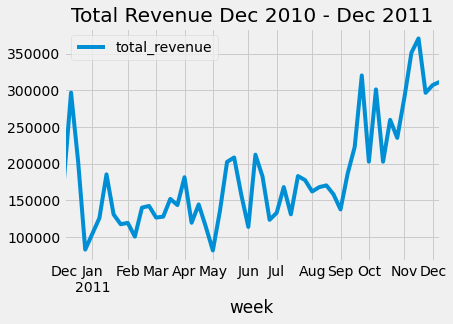

In [16]:
# Monthly sales trend
sales_monetary = sales_data.groupby('week') \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(values='total_revenue', 
                                     index='week') \
                        .plot().set(title='Total Revenue Dec 2010 - Dec 2011')

### Sales by Product

In [17]:
# Create sales by product aggregation table
sales_by_product = sales_data.groupby('stockcode_caps').agg(total_revenue=('revenue',np.sum),
                                                total_qty=('quantity',np.sum),
                                                num_invoices=('invoiceno',lambda x: x.nunique()),
                                                 unique_customers=('customerid',lambda x: x.nunique())
                                               ).reset_index()

In [18]:
# calculate average purchase amount
sales_by_product['avg_product_purchase'] = sales_by_product['total_revenue'
                                                           ] / sales_by_product['num_invoices']

In [19]:
# Check for product with sales below zero: 0.5% of products have total sales less than zero
product_negative = sales_by_product[sales_by_product['total_revenue']<0]
product_negative.shape[0]/sales_by_product.shape[0]

0.004977731202515065

In [20]:
# create product sales by decile feature
sales_by_product['prodsales_deciles'] = pd.qcut(sales_by_product.total_revenue, 
                                                10, 
                                                labels = list(range(10,0,-1)))

In [21]:
# display products by total sales deciles
sales_by_product.groupby('prodsales_deciles') \
                [['total_revenue','total_qty','num_invoices']] \
                .sum().transform(lambda x: x / x.sum()) \
                .rename_axis('Products by Total Sales Deciles')

,total_revenue,total_qty,num_invoices
Products by Total Sales Deciles,,,
10,0.00,0.00,0.00
9,0.00,0.00,0.01
8,0.01,0.01,0.02
7,0.01,0.03,0.03
6,0.02,0.04,0.05
5,0.03,0.06,0.07
4,0.05,0.09,0.10
3,0.09,0.12,0.13
2,0.17,0.19,0.19


In [120]:
# Top 5 brands with descriptions
stock_descriptions[stock_descriptions['stockcode_caps'].isin(
    sales_by_product.sort_values(by='total_revenue',ascending=False).head(5).stockcode_caps.values
)           
                  ]

,stockcode_caps,description_new,prodsales_deciles
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1
1,22423,REGENCY CAKESTAND 3 TIER,1
2,85099B,JUMBO BAG RED RETROSPOT,1
3,47566,PARTY BUNTING,1
35,23084,RABBIT NIGHT LIGHT,1


In [22]:
# Join product quintile ranking to sales_data table
sales_data = sales_data.merge(sales_by_product[['stockcode_caps','prodsales_deciles']], 
                              how='left', 
                              on='stockcode_caps')

In [23]:
# product decile descriptive stats
sales_data.groupby('prodsales_deciles').agg(
                                    total_revenue=('revenue',np.sum),
                                    total_qty=('quantity',np.sum),
                                    num_invoices=('invoiceno',lambda x: x.nunique()),
                                     unique_products=('stockcode_caps',lambda x: x.nunique()),
                                    cust_count=('customerid',lambda x: x.nunique())
                                               )

,total_revenue,total_qty,num_invoices,unique_products,cust_count
prodsales_deciles,,,,,
10,"3,826.95",3471,787,382,628
9,"19,177.01",16006,1814,382,1232
8,"52,643.98",49615,3350,381,1961
7,"117,330.04",145533,5438,382,2799
6,"213,654.16",197604,7603,382,3435
5,"335,116.76",323562,9845,381,3983
4,"534,300.58",494346,12074,382,4471
3,"878,151.56",642298,14508,381,4816
2,"1,704,316.92",983713,16808,382,5055


[Text(0.5, 1.0, 'Product sales by deciles'),
 Text(0.5, 0, 'Index of Products'),
 Text(0, 0.5, 'Total Revenue')]

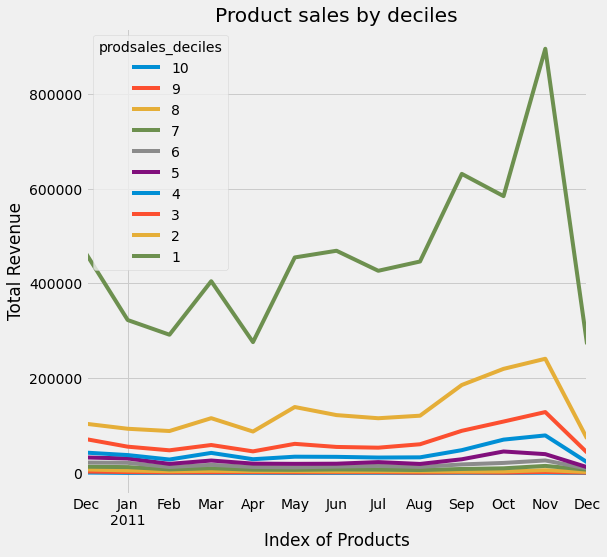

In [24]:
# monthly sales by deciles
sales_data.groupby(['yearmonth','prodsales_deciles']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='prodsales_deciles', 
                                     values='total_revenue', 
                                     index='yearmonth') \
                        .plot(figsize=(8,8)).set(title='Product sales by deciles', 
                   xlabel='Index of Products', 
                   ylabel='Total Revenue')

We plot sales by decile month to check if there are any products is the lower deciles that have a large flucuation in sales, and also if there are any decile lines converging or crossing each other. 

We plot sales by decile month to check if there are any products is the lower deciles that have a large flucuation in sales. If there are the we would see decile lines converging or crossing each other. 

As we want to exclude small products from the dataset, this analysis is done to avoid the situation where there are products that increase significantly in proportion at year end but is excluded from analysis because the percentile analysis is done over the whole period.

[Text(0.5, 1.0, 'Product sales by decile groups of lower deciles'),
 Text(0.5, 0, 'Index of Products'),
 Text(0, 0.5, 'Total Revenue')]

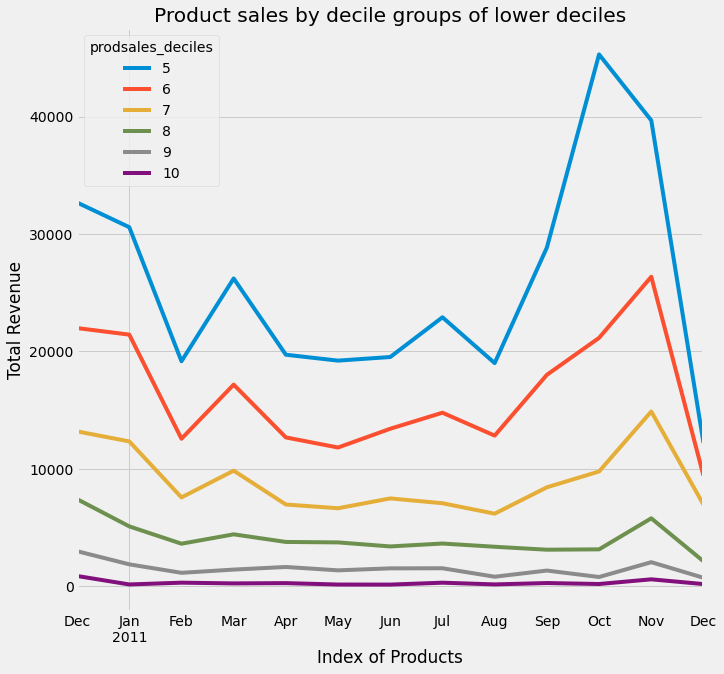

In [25]:
# monthly sales by lower deciles
sales_data.groupby(['yearmonth','prodsales_deciles']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='prodsales_deciles', 
                                     values='total_revenue', 
                                     index='yearmonth')[[5,6,7,8,9,10]] \
                        .plot(figsize=(10,10)).set(
                                title='Product sales by decile groups of lower deciles', 
                                xlabel='Index of Products', 
                                ylabel='Total Revenue')

We zoom in here on the bottom 5 deciles.

Since we do not see significant convergence or crossing of decile lines, we can be confident that the lower decile sales are not significant overall.

In [26]:
# store all data before 
sales_data_all = sales_data.copy()

[Text(0.5, 1.0, 'Product revenue by deciles')]

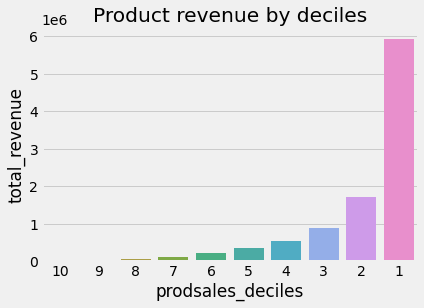

In [27]:
# revenue by product by deciles
sns.barplot(data=sales_data_all.groupby('prodsales_deciles').agg(
                                    total_revenue=('revenue',np.sum)).reset_index(), 
            x='prodsales_deciles',
           y='total_revenue').set(title='Product revenue by deciles')

In [28]:
# drop transactions of products that are in deciles 5 to 10
sales_data = sales_data[sales_data['prodsales_deciles'] >= 4].copy()

In [29]:
# join prodsales_deciles into stock_description data
stock_descriptions = stock_descriptions.merge(sales_by_product[['stockcode_caps','prodsales_deciles']],
                        on='stockcode_caps',
                        how='left')


#### Products by Month

In [30]:
# group products by month
product_by_month = sales_data \
                    .groupby(['yearmonth','stockcode_caps'])[['revenue']] \
                    .sum().reset_index()

In [31]:
product_by_month

,yearmonth,stockcode_caps,revenue
0,2010-12,10133,85.27
1,2010-12,10135,279.02
2,2010-12,11001,136.73
3,2010-12,15036,100.12
4,2010-12,15039,19.43
...,...,...,...
16658,2011-12,85183B,15.00
16659,2011-12,85184C,52.88
16660,2011-12,85199S,150.57
16661,2011-12,85227,67.09


In [32]:
# create cross tabulation of products by month
product_by_month_cross = pd.crosstab(index=product_by_month['yearmonth'],
            columns=product_by_month['stockcode_caps'],
            values=product_by_month['revenue'], 
            aggfunc=sum,
            normalize='index',
           )

In [33]:
sim_matrix_prod_month = cosine_similarity(product_by_month_cross)

In [34]:
month_sim = pd.DataFrame(sim_matrix_prod_month, 
                         columns=product_by_month_cross.index, 
                         index=product_by_month_cross.index)

[Text(0.5, 1.0, 'Similiarity of product mix by month')]

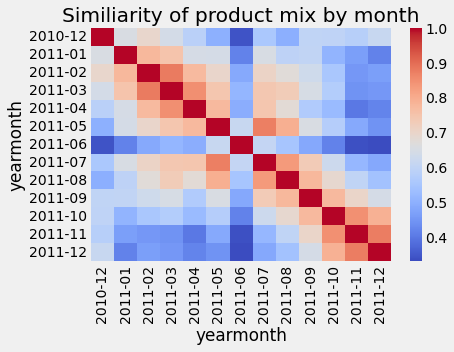

In [35]:
sns.heatmap(month_sim, cmap='coolwarm').set(
                                title='Similiarity of product mix by month')

To identify key changes of brands from month to month, we would take the absolute change in sales of each brand divided by total absolute change for all brands.

In [36]:
# key changes month to month
product_by_month_abs = pd.crosstab(index=product_by_month['yearmonth'],
            columns=product_by_month['stockcode_caps'],
            values=product_by_month['revenue'], 
            aggfunc=sum,
           ).fillna(value=0)

In [37]:
# difference from month to month
product_by_month_abs_diff = product_by_month_abs.diff(periods=1, axis=0).dropna()

In [41]:
#Top 5 growing products each month
for i in product_by_month_abs_diff.index:
    print(product_by_month_abs_diff.loc[i].sort_values(ascending=False).head(5))

stockcode_caps
21108    6,199.97
85123A   5,367.18
48185    4,616.64
22720    3,745.90
21175    3,704.15
Name: 2011-01, dtype: float64
stockcode_caps
21623   6,569.86
22053   3,296.67
22693   3,247.35
22189   2,286.84
47566   2,059.54
Name: 2011-02, dtype: float64
stockcode_caps
22423    6,364.56
47566    4,750.37
85099B   4,502.79
85099F   4,022.18
22386    3,106.46
Name: 2011-03, dtype: float64
stockcode_caps
47556B   2,730.00
23199    2,325.01
23206    2,091.77
22727    1,950.20
22693    1,882.56
Name: 2011-04, dtype: float64
stockcode_caps
47566    8,799.13
23298    8,138.72
85123A   6,292.48
23284    5,729.06
23203    4,695.24
Name: 2011-05, dtype: float64
stockcode_caps
22502   37,410.30
23245    6,509.52
21137    3,970.01
23173    3,849.60
22720    3,547.11
Name: 2011-06, dtype: float64
stockcode_caps
22423    4,311.17
85123A   3,958.15
23297    3,086.88
47566    2,119.38
23296    2,009.53
Name: 2011-07, dtype: float64
stockcode_caps
84879    6,752.76
85099B   4,368.14
23199    

Generally the product mix from month to month is quite correlated. The correlation reaches about 0.5 around 3 months. June seems particuarly different from December, and this could be a seasonal impact as well due to diffrent gifts during the summer and winter holidays.

### Analysis of Sales by Customer

In [47]:
# get latest date
latest_date = sales_data['invoicedate'].max()

In [49]:
# create table of sales by customer
sales_by_cust = sales_data.groupby('customerid').agg(total_revenue=('revenue',np.sum),
                                                total_qty=('quantity',np.sum),
                                                unique_products=('stockcode_caps',lambda x: x.nunique()),
                                               ).reset_index()

In [50]:
# 76 customers with zero sales or less
sales_by_cust_zero = sales_by_cust[sales_by_cust['total_revenue']<=0]
sales_by_cust_zero

,customerid,total_revenue,total_qty,unique_products
0,12346,0.00,0,1
89,12454,0.00,0,11
168,12558,0.00,0,9
210,12605,-7.50,-4,3
211,12607,0.00,0,92
...,...,...,...,...
5683,C574288,-14.75,-1,1
5684,C575153,-33.17,-1,1
5685,C577779,-96.00,-96,1
5686,C578097,"-1,208.04",-324,7


In [51]:
# Drop customers that have zero sales from sales_data
sales_data = sales_data[~sales_data['customerid'].isin(sales_by_cust_zero['customerid'])].copy()

In [52]:
# select only customers with sales more than zero
sales_by_cust = sales_by_cust[sales_by_cust['total_revenue']>0].copy()

In [53]:
# calculate recency and number of invoices from positive invoices only
sales_by_cust = sales_by_cust.merge(
                    sales_data[sales_data['revenue']>0].groupby('customerid').agg(
                        num_invoices=('invoiceno', lambda x: x.nunique()),
                        recency=('invoicedate', lambda x: (latest_date - x.max()).days)),
                    on = 'customerid',
                    how = 'left'
                    )

In [54]:
sales_by_cust.head()

,customerid,total_revenue,total_qty,unique_products,num_invoices,recency
0,12347,"3,464.79",1965,80,7,1
1,12348,"1,334.28",2116,18,4,74
2,12349,"1,390.34",582,67,1,18
3,12350,200.40,132,10,1,309
4,12352,"1,227.71",441,55,7,35


In [55]:
sales_by_cust

,customerid,total_revenue,total_qty,unique_products,num_invoices,recency
0,12347,"3,464.79",1965,80,7,1
1,12348,"1,334.28",2116,18,4,74
2,12349,"1,390.34",582,67,1,18
3,12350,200.40,132,10,1,309
4,12352,"1,227.71",441,55,7,35
...,...,...,...,...,...,...
5606,581435,2.10,1,1,1,0
5607,581439,"5,091.97",1472,490,1,0
5608,581492,"5,618.71",1533,507,1,0
5609,581497,"3,217.20",654,56,1,0


In [56]:
# create product sales by decile feature
sales_by_cust['cust_deciles'] = pd.qcut(sales_by_cust.total_revenue, 
                                                10, 
                                                labels = list(range(10,0,-1)))

In [57]:
# display sales by customer deciles
sales_by_cust.groupby('cust_deciles') \
                [['total_revenue','total_qty','num_invoices']] \
                .sum().transform(lambda x: x / x.sum()) \
                .rename_axis('Customers by Total Sales Deciles')

,total_revenue,total_qty,num_invoices
Customers by Total Sales Deciles,,,
10,0.00,0.00,0.03
9,0.01,0.01,0.03
8,0.01,0.02,0.04
7,0.02,0.02,0.04
6,0.03,0.03,0.05
5,0.04,0.04,0.07
4,0.06,0.06,0.09
3,0.09,0.08,0.11
2,0.14,0.15,0.16


[Text(0.5, 1.0, 'Customer revenue by deciles')]

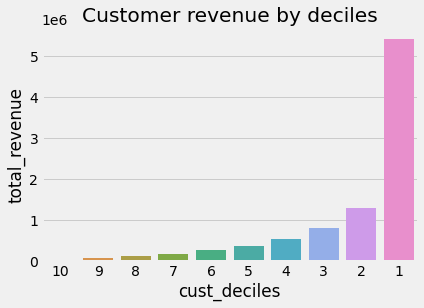

In [58]:
sns.barplot(data=sales_by_cust.groupby('cust_deciles').agg(
                                    total_revenue=('total_revenue',np.sum)).reset_index(), 
            x='cust_deciles',
           y='total_revenue').set(title='Customer revenue by deciles')

[Text(0.5, 1.0, 'Product revenue by deciles')]

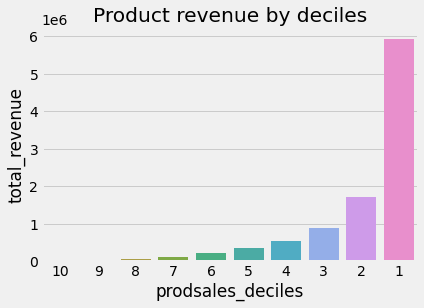

In [59]:
sns.barplot(data=sales_data_all.groupby('prodsales_deciles').agg(
                                    total_revenue=('revenue',np.sum)).reset_index(), 
            x='prodsales_deciles',
           y='total_revenue').set(title='Product revenue by deciles')

Text(0.5, 1.02, 'Customer RFM distribution')

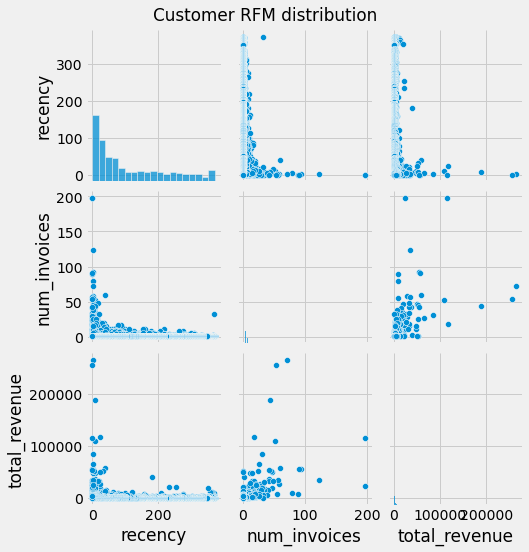

In [62]:
# Display pairplot of customer distribution by Recency, Frequency and Monetary value
g = sns.pairplot(data=sales_by_cust[['recency','num_invoices','total_revenue']])
g.fig.suptitle("Customer RFM distribution", y=1.02)

Most customers have spent within $25,000 and have invoices of around 60 or less.

Recency and Frequency (num_invoices): There are many customers that are very recent, with few number of invoices. Also, they have low in total revenue. We will try to identify customers that are likely new, if they have only purchases that are the most recent and no previous purchasing history.

In [63]:
sales_by_cust['custsales_quntiles'] = pd.qcut(sales_by_cust.total_revenue, 5, labels = [5,4,3,2,1])

In [64]:
sales_by_cust.groupby(pd.qcut(sales_by_cust['total_revenue'], 5, labels = [5,4,3,2,1])) \
                [['total_revenue','total_qty','num_invoices']].sum().transform(lambda x: x / x.sum()) \
                .rename_axis('Customer by Total Sales Quintile')

,total_revenue,total_qty,num_invoices
Customer by Total Sales Quintile,,,
5,0.01,0.01,0.06
4,0.03,0.04,0.08
3,0.07,0.07,0.13
2,0.15,0.14,0.19
1,0.74,0.74,0.53


#### Purchase Frequency: Recency and New customers
For a more relevant metric of customer recency, we would analyze the typical purchase behavior of customers with regards to the timing between purchases

In [65]:
# Create sales data aggregated by customer and invoice
sales_by_cust_invoice = sales_data.groupby(['customerid','invoiceno','invoicedate']) \
                                .agg(total_revenue=('revenue',np.sum),
                                     total_qty=('quantity',np.sum),
                                     unique_products=('stockcode_caps',lambda x: x.nunique()),
                               ).reset_index()

In [66]:
# Count positive invoices per customer
invoice_counts = sales_by_cust_invoice[sales_by_cust_invoice['total_revenue']>0] \
                    .groupby('customerid').agg(
                            count_invoice=('invoiceno',np.size),
                            total_revenue=('total_revenue',np.sum)
                    )
invoice_counts.describe()

,count_invoice,total_revenue
count,"5,611.00","5,611.00"
mean,3.46,"1,648.78"
std,6.68,"7,225.21"
min,1.00,0.42
25%,1.00,215.65
50%,2.00,563.15
75%,4.00,"1,414.57"
max,197.00,"264,985.92"


In [67]:
# Select only positive sales invoices
positive_sales = sales_by_cust_invoice[(sales_by_cust_invoice['total_revenue']>0)]

In [68]:
positive_sales['customerid'].value_counts().index

Index(['12748', '14911', '17841', '13089', '15311', '14606', '12971', '14646',
       '16029', '13408',
       ...
       '16793', '16769', '13002', '16773', '16776', '16781', '12995', '16784',
       '16789', '581498'],
      dtype='object', length=5611)

In [69]:
# Calculate time between each purchases for each customer
time_diff = []
for i in positive_sales['customerid'].value_counts().index:
    invoice_dates = positive_sales[positive_sales['customerid'] == i] \
            .sort_values('invoicedate', ascending=True)['invoicedate'].tolist()
    if len(invoice_dates) > 1:
        for j in range(len(invoice_dates)-1):
            time_diff.append([i, invoice_dates[j+1] - invoice_dates[j]])
    else:
        continue

time_between_purchases = pd.DataFrame(time_diff, 
                                      columns=['customerid','time_between_purchases'])        

Text(54, 2100, '75th percentile: 52 days')

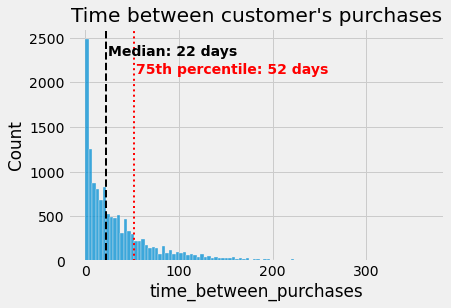

In [70]:
# Plot distribution of time between purchases
sns.histplot(time_between_purchases['time_between_purchases'].dt.days.sort_values()) \
    .set(title='Time between customer\'s purchases')
plt.axvline(22, color = 'black', linestyle = '--', linewidth=2)
plt.axvline(52, color = 'red', linestyle = ':', linewidth=2)
plt.text(24, 2300, "Median: 22 days", horizontalalignment='left', size='medium', 
         color='black', weight='semibold')
plt.text(54, 2100, "75th percentile: 52 days", horizontalalignment='left', size='medium', 
         color='red', weight='semibold')

In [71]:
# Overall statistics for time between purchases
time_between_purchases.groupby(lambda _ : True) \
                    .agg(count_return_purchases=('time_between_purchases',np.size),
                         median_duration=('time_between_purchases',np.median),
                         mean_duration=('time_between_purchases',np.mean),
                         min_duration=('time_between_purchases',np.min),
                         max_duration=('time_between_purchases',np.max)
                        )

,count_return_purchases,median_duration,mean_duration,min_duration,max_duration
True,13794,22 days 21:13:30,40 days 19:23:40.687255328,0 days 00:01:00,365 days 23:34:00


In [72]:
# statistics by customer for time between purchases
cust_purchases_delta = time_between_purchases.groupby('customerid') \
                            .agg(count_return_purchases=('time_between_purchases',np.size),
                                 median_duration=('time_between_purchases',np.median),
                                 mean_duration=('time_between_purchases',np.mean),
                                 min_duration=('time_between_purchases',np.min),
                                 max_duration=('time_between_purchases',np.max)
                               )

In [73]:
time_between_purchases.describe()

,time_between_purchases
count,13794
mean,40 days 19:23:40.687255328
std,52 days 01:11:21.321129634
min,0 days 00:01:00
25%,7 days 00:48:15
50%,22 days 21:13:30
75%,52 days 02:27:00
max,365 days 23:34:00


In [74]:
# set 50% percentile and 75% percentile as recency score bins. 
# If customer has not bought in 51 days, its likely that they are lost customers 
sales_by_cust['recency_score'] = pd.cut(sales_by_cust.recency, 
                                        bins=[0,22,52,np.infty], 
                                        labels=[3,2,1],
                                       include_lowest=True
                                       )

In [75]:
# create invoice recency table
invoice_recency = positive_sales.groupby('customerid') \
            .agg(total_revenue=('total_revenue',np.sum),
                count_invoice=('invoiceno',np.size),
                earliest_invoice_age=('invoicedate',lambda x: (latest_date - x.min()).days),
                latest_invoice_age=('invoicedate',lambda x: (latest_date - x.max()).days))


In [76]:
# create recency score of last invoice
invoice_recency['recency_score'] = pd.cut(invoice_recency.latest_invoice_age, 
                                        bins=[0,22,51,np.infty], 
                                        labels=[3,2,1],
                                       include_lowest=True
                                       )

In [77]:
# create recency score of earlest invoice
invoice_recency['recency_score_earliest'] = pd.cut(invoice_recency.earliest_invoice_age, 
                                        bins=[0,22,51,np.infty], 
                                        labels=[3,2,1],
                                       include_lowest=True
                                       )

In [78]:
invoice_recency

,total_revenue,count_invoice,earliest_invoice_age,latest_invoice_age,recency_score,recency_score_earliest
customerid,,,,,,
12347,"3,464.79",7,366,1,3,1
12348,"1,334.28",4,357,74,1,1
12349,"1,390.34",1,18,18,3,3
12350,200.40,1,309,309,1,1
12352,"1,330.34",7,296,35,2,1
...,...,...,...,...,...,...
581435,2.10,1,0,0,3,3
581439,"5,091.97",1,0,0,3,3
581492,"5,618.71",1,0,0,3,3


In [79]:
invoice_recency.groupby(['recency_score_earliest','recency_score']) \
            .agg(total_revenue=('total_revenue',np.sum),
                avg_count_invoice=('count_invoice',np.mean),
                avg_earliest_invoice_age=('earliest_invoice_age',np.mean),
                avg_latest_invoice_age=('latest_invoice_age',np.mean))


total_revenue  avg_count_invoice  \
recency_score_earliest recency_score                                     
3                      3                 288,409.29               1.15   
                       2                       0.00                NaN   
                       1                       0.00                NaN   
2                      3                  66,897.64               2.61   
                       2                 314,168.27               1.08   
                       1                       0.00                NaN   
1                      3               4,942,262.00               9.20   
                       2               1,209,298.96               4.87   
                       1               2,430,294.86               1.71   

                                      avg_earliest_invoice_age  \
recency_score_earliest recency_score                             
3                      3                                 11.69   
                       2                                   NaN   
                       1                                   NaN   
2                      3                                 37.30   
                       2                                 36.79   
                       1                                   NaN   
1                      3                                270.68   
                       2                                254.68   
                       1                                230.57   

                                      avg_latest_invoice_age  
recency_score_earliest recency_score                          
3                      3                               11.08  
                       2                                 NaN  
                       1                                 NaN  
2                      3                                8.61  
                       2                               36.24  
                       1                                 NaN  
1                      3                                9.49  
                       2                               34.64  
                       1                              186.21

We will take new customers with earliest purchases less than 22 days as new customers

In [80]:
# Get customerid of new customers
new_cust_list = invoice_recency[(invoice_recency['recency_score_earliest']==3) 
                         & (invoice_recency['recency_score']==3)].index.tolist()

In [81]:
# Create feature to indicate new customer in sales data table
sales_data['new_cust'] = sales_data['customerid'].isin(new_cust_list)
sales_by_cust['new_cust'] = sales_by_cust['customerid'].isin(new_cust_list)

#### RFM Analysis

In [82]:
sales_by_cust['frequency_score'] = pd.qcut(sales_by_cust.num_invoices.rank(method='first'), 
                                           3, 
                                           labels = [1,2,3])

In [83]:
sales_by_cust['monetary_score'] = pd.qcut(sales_by_cust.total_revenue.rank(method='first'), 
                                          3, 
                                          labels = [1,2,3])

In [84]:
sales_by_cust['RFM_group'] = sales_by_cust[['recency_score',
                                            'frequency_score',
                                            'monetary_score']].astype('str').agg(''.join, axis=1)

In [85]:
sales_by_cust.groupby('RFM_group').agg(cust_count=('customerid',np.size),
                                        total_revenue=('total_revenue',np.sum),
                                        avg_recency=('recency',np.mean),
                                        avg_invoices=('num_invoices',np.mean),
                                        avg_revenue=('total_revenue',np.mean),
                                       new_cust = ('new_cust',np.sum)
                                               ).reset_index().sort_values(by='total_revenue',
                                                                           ascending=False)

,RFM_group,cust_count,total_revenue,avg_recency,avg_invoices,avg_revenue,new_cust
26,333,737,"4,624,383.65",8.41,12.06,"6,274.60",3
17,233,285,"978,919.24",34.56,7.04,"3,434.80",0
8,133,235,"600,607.11",103.14,5.38,"2,555.77",0
5,123,296,"557,897.71",145.53,1.33,"1,884.79",0
2,113,154,"381,402.79",273.46,1.00,"2,476.64",0
4,122,474,"280,484.37",162.98,1.65,591.74,0
14,223,75,"274,491.82",37.05,1.52,"3,659.89",0
23,323,78,"264,735.84",10.41,1.54,"3,394.05",49
1,112,423,"215,894.06",207.78,1.00,510.39,0
25,332,212,"152,994.19",10.71,4.39,721.67,2


In [86]:
sales_by_cust

,customerid,total_revenue,total_qty,unique_products,num_invoices,recency,cust_deciles,custsales_quntiles,recency_score,new_cust,frequency_score,monetary_score,RFM_group
0,12347,"3,464.79",1965,80,7,1,1,1,3,False,3,3,333
1,12348,"1,334.28",2116,18,4,74,3,2,1,False,3,3,133
2,12349,"1,390.34",582,67,1,18,3,2,3,True,1,3,313
3,12350,200.40,132,10,1,309,8,4,1,False,1,1,111
4,12352,"1,227.71",441,55,7,35,3,2,2,False,3,3,233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5606,581435,2.10,1,1,1,0,10,5,3,True,2,1,321
5607,581439,"5,091.97",1472,490,1,0,1,1,3,True,2,3,323
5608,581492,"5,618.71",1533,507,1,0,1,1,3,True,2,3,323
5609,581497,"3,217.20",654,56,1,0,1,1,3,True,2,3,323


In [87]:
sales_by_cust.groupby(['recency_score','frequency_score']).agg(
                                            num_cust=('customerid',np.size),
                                            num_new_cust=('new_cust',np.sum),
                                            maxinvoice=('num_invoices',np.max),
                                            mininvoice=('num_invoices',np.min),
                                            avg_recency=('recency',np.mean),
                                            avg_invoices=('num_invoices',np.mean),
                                            total_revenue=('total_revenue',np.sum))

num_cust  num_new_cust  maxinvoice  mininvoice  \
recency_score frequency_score                                                   
3             1                     153           153           1           1   
              2                     338           114           3           1   
              3                     963             7         197           3   
2             1                     245             0           1           1   
              2                     293             0           3           1   
              3                     440             0          60           3   
1             1                    1473             0           1           1   
              2                    1239             0           3           1   
              3                     467             0          33           3   

                               avg_recency  avg_invoices  total_revenue  
recency_score frequency_score                                            
3             1                      12.53          1.00      41,108.77  
              2                      10.77          1.81     368,446.35  
              3                       8.94         10.25   4,780,783.08  
2             1                      37.51          1.00      81,327.51  
              2                      36.18          1.73     356,176.53  
              3                      34.57          5.89   1,083,298.70  
1             1                     232.78          1.00     720,333.14  
              2                     160.79          1.45     890,048.77  
              3                     115.96          4.62     737,775.77

In [88]:
sales_by_cust.loc[(sales_by_cust['recency_score'] == 3) & 
            (sales_by_cust['frequency_score'] >= 2) &
            (sales_by_cust['new_cust'] == False),'cust_matrix'] = 'star_cust'

In [89]:
sales_by_cust.loc[(sales_by_cust['new_cust'] == True),'cust_matrix'] = 'new_cust'

In [90]:
sales_by_cust.loc[(sales_by_cust['recency_score'] == 2) & 
                (sales_by_cust['frequency_score'] >= 2) &
                (sales_by_cust['new_cust'] == False),'cust_matrix'] = 'problem_cust'

In [91]:
sales_by_cust.loc[((sales_by_cust['recency_score'] == 1) | 
            (sales_by_cust['frequency_score'] == 1)) &
                (sales_by_cust['new_cust'] == False),'cust_matrix'] = 'lost_cust'

In [92]:
sales_by_cust.groupby(['cust_matrix'],dropna=False).agg(
                                            num_cust=('customerid',np.size),
                                            num_new_cust=('new_cust',np.sum),
                                            maxinvoice=('num_invoices',np.max),
                                            mininvoice=('num_invoices',np.min),
                                            avg_recency=('recency',np.mean),
                                            avg_invoices=('num_invoices',np.mean),
                                            total_revenue=('total_revenue',np.sum))

,num_cust,num_new_cust,maxinvoice,mininvoice,avg_recency,avg_invoices,total_revenue
cust_matrix,,,,,,,
lost_cust,3424,0,33,1,176.83,1.66,"2,429,485.18"
new_cust,274,274,6,1,11.08,1.15,"287,962.00"
problem_cust,733,0,60,1,35.21,4.23,"1,439,475.23"
star_cust,1180,0,197,2,9.43,8.75,"4,902,376.20"


In [93]:
sales_by_cust

,customerid,total_revenue,total_qty,unique_products,num_invoices,recency,cust_deciles,custsales_quntiles,recency_score,new_cust,frequency_score,monetary_score,RFM_group,cust_matrix
0,12347,"3,464.79",1965,80,7,1,1,1,3,False,3,3,333,star_cust
1,12348,"1,334.28",2116,18,4,74,3,2,1,False,3,3,133,lost_cust
2,12349,"1,390.34",582,67,1,18,3,2,3,True,1,3,313,new_cust
3,12350,200.40,132,10,1,309,8,4,1,False,1,1,111,lost_cust
4,12352,"1,227.71",441,55,7,35,3,2,2,False,3,3,233,problem_cust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5606,581435,2.10,1,1,1,0,10,5,3,True,2,1,321,new_cust
5607,581439,"5,091.97",1472,490,1,0,1,1,3,True,2,3,323,new_cust
5608,581492,"5,618.71",1533,507,1,0,1,1,3,True,2,3,323,new_cust
5609,581497,"3,217.20",654,56,1,0,1,1,3,True,2,3,323,new_cust


Merge customer data for export

In [94]:
customer_location = customer_location.merge(sales_by_cust[['customerid','recency_score',
                                        'frequency_score','monetary_score','cust_matrix']], 
                                        on='customerid', 
                                        how='left')

#### Sales by month by RFM segments

In [95]:
sales_data

,invoiceno,stockcode_caps,quantity,unitprice,customerid,domestic,invoicedate,revenue,yearmonth,quarter,week,prodsales_deciles,new_cust
4,537626,21064,6,5.95,12347,False,2010-12-07 14:57:00,35.70,2010-12,2010Q4,2010-12-06/2010-12-12,4,False
6,537626,21731,12,1.65,12347,False,2010-12-07 14:57:00,19.80,2010-12,2010Q4,2010-12-06/2010-12-12,1,False
7,537626,22195,12,1.65,12347,False,2010-12-07 14:57:00,19.80,2010-12,2010Q4,2010-12-06/2010-12-12,2,False
8,537626,22212,6,2.10,12347,False,2010-12-07 14:57:00,12.60,2010-12,2010Q4,2010-12-06/2010-12-12,2,False
9,537626,22375,4,4.25,12347,False,2010-12-07 14:57:00,17.00,2010-12,2010Q4,2010-12-06/2010-12-12,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525707,581498,85049E,4,3.29,581498,True,2011-12-09 10:26:00,13.16,2011-12,2011Q4,2011-12-05/2011-12-11,2,True
525708,581498,85099B,5,4.13,581498,True,2011-12-09 10:26:00,20.65,2011-12,2011Q4,2011-12-05/2011-12-11,1,True
525709,581498,85099C,4,4.13,581498,True,2011-12-09 10:26:00,16.52,2011-12,2011Q4,2011-12-05/2011-12-11,1,True
525710,581498,85150,1,4.96,581498,True,2011-12-09 10:26:00,4.96,2011-12,2011Q4,2011-12-05/2011-12-11,1,True


In [96]:
sales_data = sales_data.merge(sales_by_cust[['customerid',
                                             'recency_score',
                                             'frequency_score',
                                             'monetary_score',
                                             'cust_matrix']], 
                              how='left',
                             on='customerid',)

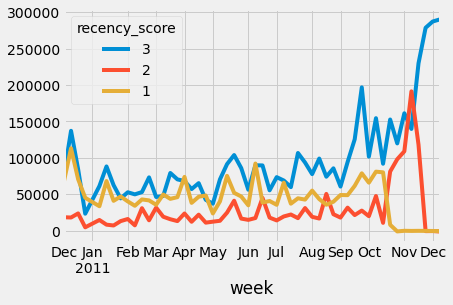

In [97]:
sales_recency = sales_data.groupby(['week','recency_score']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='recency_score', 
                                     values='total_revenue', 
                                     index='week') \
                        .plot()

Overall, there is a upward spike in sales in November, presumably in preparation for the Christmas season. Theres a significant drop in sales from recency group 1 in Nov, given that the sales was pretty constant throught the year just over $20k a month, but it dropped off quickly in November. Further analysis would be done to see if there were any significant customers that were lost in this segment.

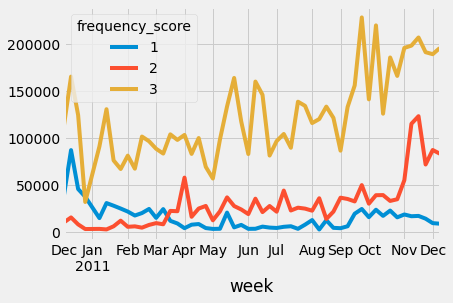

In [98]:
sales_frequency = sales_data.groupby(['week','frequency_score']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='frequency_score', 
                                     values='total_revenue', 
                                     index='week') \
                        .plot()

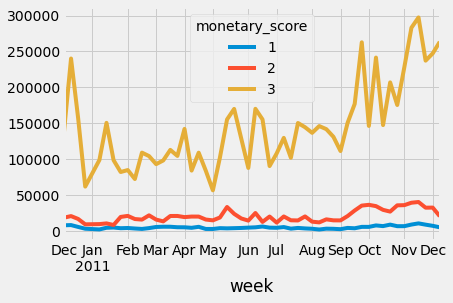

In [99]:
sales_monetary = sales_data.groupby(['week','monetary_score']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='monetary_score', 
                                     values='total_revenue', 
                                     index='week') \
                        .plot()

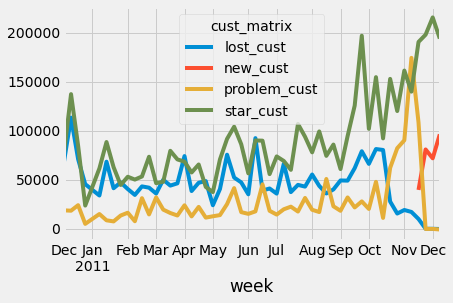

In [100]:
sales_monetary = sales_data.groupby(['week','cust_matrix']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='cust_matrix', 
                                     values='total_revenue', 
                                     index='week') \
                        .plot()

[Text(0.5, 1.0, 'Customer count')]

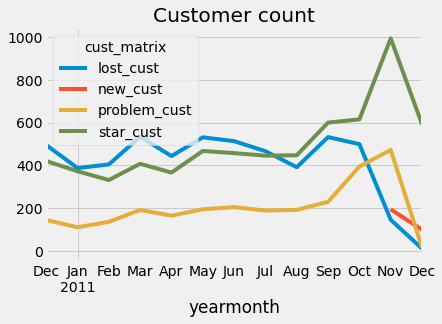

In [101]:
# customer by month
sales_data[['yearmonth','cust_matrix','customerid']
          ].value_counts().reset_index().drop(columns=0) \
            .groupby(['yearmonth','cust_matrix']).agg(customer_count=('customerid',np.size)) \
            .pivot_table(columns='cust_matrix', 
                                     values='customer_count', 
                                     index='yearmonth').plot() \
            .set(title='Customer count')

We would drop lost customers and monetary score 1 from the dataset for modelling

In [104]:
sales_data_filtered = sales_data[sales_data['cust_matrix'] != 'lost_cust']

In [105]:
sales_data_filtered = sales_data_filtered[sales_data_filtered['monetary_score']!=1]

### Export to CSV

In [106]:
selected_columns = ['invoiceno', 'stockcode_caps', 'quantity', 'unitprice', 'customerid']

In [107]:
sales_data_filtered[selected_columns].to_csv('../data/processed_sales.csv', index=False)

In [108]:
customer_location.to_csv('../data/processed_customer.csv', index=False)

In [109]:
stock_descriptions.to_csv('../data/processed_stock_descriptions.csv', index=False)